# **Intelligent Meeting Notes**

## **Project Description**

The **Intelligent Meeting Notes** Assistant aims to automate the generation of structured meeting summaries from audio recordings of city council meetings. This system seeks to streamline the meeting documentation process by converting spoken dialogue into concise, actionable summaries. By leveraging transformer-based models, the project will transcribe the audio content and extract key insights, decisions, and action points, ensuring that important information is easily accessible and reducing the manual effort involved in documenting meetings 🤗.

## Dataset Selection and Objectives
MeetingBank, a benchmark dataset created from the city councils of 6 major U.S. cities to supplement existing datasets. It contains 1,366 meetings with over 3,579 hours of video, as well as transcripts, PDF documents of meeting minutes, agenda, and other metadata. On average, a council meeting is 2.6 hours long and its transcript contains over 28k tokens, making it a valuable testbed for meeting summarizers and for extracting structure from meeting videos. The datasets contains 6,892 segment-level summarization instances for training and evaluating of performance.

For each instance in the dataset, we have:
* MP3 meeting audio
* JSON Transcript containing the words said within their respective timestamps (.e.g "15s-20s: Hello Medtech and goodbye 🤗!"

### Import Packages

In [54]:
import re
import os
from glob import glob
import tensorflow as tf
import keras
from keras import layers
import json
from pydub import AudioSegment

## **Define Transformer Input Layer**

**TokenEmbedding** converts words into numerical representations while incorporating their positions in a sequence, helping the model understand both meaning and order. 

**SpeechFeatureEmbedding**, on the other hand, extracts meaningful patterns from audio features like spectrograms through convolutional layers, simplifying the data for efficient analysis. Together, they enable systems to handle complex tasks like speech recognition🤗 .

In [55]:

class TokenEmbedding(layers.Layer):
    def __init__(self, num_vocab, maxlen=100, num_hid=64):
        super().__init__()
        self.emb = keras.layers.Embedding(num_vocab, num_hid)
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=num_hid)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        x = self.emb(x)
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        return x + positions


class SpeechFeatureEmbedding(layers.Layer):
    def __init__(self, num_hid=64, maxlen=100):
        super().__init__()
        self.conv1 = keras.layers.Conv1D(
            num_hid, 11, strides=2, padding="same", activation="relu"
        )
        self.conv2 = keras.layers.Conv1D(
            num_hid, 11, strides=2, padding="same", activation="relu"
        )
        self.conv3 = keras.layers.Conv1D(
            num_hid, 11, strides=2, padding="same", activation="relu"
        )

    def call(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        return self.conv3(x)


## **Transformer Encoder Layer**

In [56]:

class TransformerEncoder(layers.Layer):
    def __init__(self, embed_dim, num_heads, feed_forward_dim, rate=0.1):
        super().__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = keras.Sequential(
            [
                layers.Dense(feed_forward_dim, activation="relu"),
                layers.Dense(embed_dim),
            ]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training=False):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)


## **Transformer Decoder Layer**

In [57]:

class TransformerDecoder(layers.Layer):
    def __init__(self, embed_dim, num_heads, feed_forward_dim, dropout_rate=0.1):
        super().__init__()
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm3 = layers.LayerNormalization(epsilon=1e-6)
        self.self_att = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim
        )
        self.enc_att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.self_dropout = layers.Dropout(0.5)
        self.enc_dropout = layers.Dropout(0.1)
        self.ffn_dropout = layers.Dropout(0.1)
        self.ffn = keras.Sequential(
            [
                layers.Dense(feed_forward_dim, activation="relu"),
                layers.Dense(embed_dim),
            ]
        )

    def causal_attention_mask(self, batch_size, n_dest, n_src, dtype):
        """Masks the upper half of the dot product matrix in self attention.

        This prevents flow of information from future tokens to current token.
        1's in the lower triangle, counting from the lower right corner.
        """
        i = tf.range(n_dest)[:, None]
        j = tf.range(n_src)
        m = i >= j - n_src + n_dest
        mask = tf.cast(m, dtype)
        mask = tf.reshape(mask, [1, n_dest, n_src])
        mult = tf.concat(
            [tf.expand_dims(batch_size, -1), tf.constant([1, 1], dtype=tf.int32)], 0
        )
        return tf.tile(mask, mult)

    def call(self, enc_out, target):
        input_shape = tf.shape(target)
        batch_size = input_shape[0]
        seq_len = input_shape[1]
        causal_mask = self.causal_attention_mask(batch_size, seq_len, seq_len, tf.bool)
        target_att = self.self_att(target, target, attention_mask=causal_mask)
        target_norm = self.layernorm1(target + self.self_dropout(target_att))
        enc_out = self.enc_att(target_norm, enc_out)
        enc_out_norm = self.layernorm2(self.enc_dropout(enc_out) + target_norm)
        ffn_out = self.ffn(enc_out_norm)
        ffn_out_norm = self.layernorm3(enc_out_norm + self.ffn_dropout(ffn_out))
        return ffn_out_norm


## **Define the Transformer class**
Our model takes audio spectrograms as inputs and predicts a sequence of characters. During training, we give the decoder the target character sequence shifted to the left as input. During inference, the decoder uses its own past predictions to predict the next token. 🤗

In [58]:

class Transformer(keras.Model):
    def __init__(
        self,
        num_hid=64,
        num_head=2,
        num_feed_forward=128,
        source_maxlen=100,
        target_maxlen=100,
        num_layers_enc=4,
        num_layers_dec=1,
        num_classes=10,
    ):
        super().__init__()
        self.loss_metric = keras.metrics.Mean(name="loss")
        self.num_layers_enc = num_layers_enc
        self.num_layers_dec = num_layers_dec
        self.target_maxlen = target_maxlen
        self.num_classes = num_classes

        self.enc_input = SpeechFeatureEmbedding(num_hid=num_hid, maxlen=source_maxlen)
        self.dec_input = TokenEmbedding(
            num_vocab=num_classes, maxlen=target_maxlen, num_hid=num_hid
        )

        self.encoder = keras.Sequential(
            [self.enc_input]
            + [
                TransformerEncoder(num_hid, num_head, num_feed_forward)
                for _ in range(num_layers_enc)
            ]
        )

        for i in range(num_layers_dec):
            setattr(
                self,
                f"dec_layer_{i}",
                TransformerDecoder(num_hid, num_head, num_feed_forward),
            )

        self.classifier = layers.Dense(num_classes)

    def decode(self, enc_out, target):
        y = self.dec_input(target)
        for i in range(self.num_layers_dec):
            y = getattr(self, f"dec_layer_{i}")(enc_out, y)
        return y

    def call(self, inputs):
        source = inputs[0]
        target = inputs[1]
        x = self.encoder(source)
        y = self.decode(x, target)
        return self.classifier(y)

    @property
    def metrics(self):
        return [self.loss_metric]

    def train_step(self, batch):
        """Processes one batch inside model.fit()."""
        source = batch["source"]
        target = batch["target"]
        dec_input = target[:, :-1]
        dec_target = target[:, 1:]
        with tf.GradientTape() as tape:
            preds = self([source, dec_input])
            one_hot = tf.one_hot(dec_target, depth=self.num_classes)
            mask = tf.math.logical_not(tf.math.equal(dec_target, 0))
            loss = model.compute_loss(None, one_hot, preds, sample_weight=mask)
        trainable_vars = self.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))
        self.loss_metric.update_state(loss)
        return {"loss": self.loss_metric.result()}

    def test_step(self, batch):
        source = batch["source"]
        target = batch["target"]
        dec_input = target[:, :-1]
        dec_target = target[:, 1:]
        preds = self([source, dec_input])
        one_hot = tf.one_hot(dec_target, depth=self.num_classes)
        mask = tf.math.logical_not(tf.math.equal(dec_target, 0))
        loss = model.compute_loss(None, one_hot, preds, sample_weight=mask)
        self.loss_metric.update_state(loss)
        return {"loss": self.loss_metric.result()}

    def generate(self, source, target_start_token_idx):
        """Performs inference over one batch of inputs using greedy decoding."""
        bs = tf.shape(source)[0]
        enc = self.encoder(source)
        dec_input = tf.ones((bs, 1), dtype=tf.int32) * target_start_token_idx
        dec_logits = []
        for i in range(self.target_maxlen - 1):
            dec_out = self.decode(enc, dec_input)
            logits = self.classifier(dec_out)
            logits = tf.argmax(logits, axis=-1, output_type=tf.int32)
            last_logit = tf.expand_dims(logits[:, -1], axis=-1)
            dec_logits.append(last_logit)
            dec_input = tf.concat([dec_input, last_logit], axis=-1)
        return dec_input


## Data Preparation

We start by iterating over the provided ids, which are unique identifiers for the meeting audio files. For each ID, it loads the corresponding transcription from a JSON file located in boston-transcript. Each transcription contains several segments of text that correspond to portions of the audio. 🤗

The data preparation pipeline involves extracting smaller chunks of audio from larger meeting recordings, pairing them with transcriptions, and organizing them into a structured format for training. This ensures that the audio-to-text model can learn from manageable, well-labeled segments, making it ready for the training process of your transformer-based ASR system. 🤗

In [48]:
id_to_text = {}
def loadDataset(ids):
    for id in ids:
        with open(f"/kaggle/input/boston-transcript/{id}.mp3.transcript.json", "r") as f:
            data = json.load(f)
        
        audio = AudioSegment.from_mp3(f"/kaggle/input/boston-meeting-audio/{id}.mp3")
        segments = data["segments"]
        
        start = 0
        for i, segment in enumerate(segments):
            offset = int(segment["offset"] / 10000)
            duration = int(segment["duration"] / 10000)
            end_time = offset + duration
        
            chunk = audio[start:end_time]
            start = end_time
        
            transcript = segment["nbest"][0]["text"]
        
            chunk_filename = f"chunk_{i + 1}-{id}.wav"
            chunk.export(chunk_filename, format="wav")
            
            id_to_text[chunk_filename] = transcript

loadDataset(['boston_ff7cd3a9-f0f6-41f2-8470-62b10d474400','boston_cde8ac15-c201-4a69-9353-84994ddbc01a', 'boston_e76cc935-bdc6-4906-bdb3-262a1eecdb85', 'boston_e62eb100-be3a-443c-a39d-17a3e452175b'])

In [59]:
wavs = glob("*.wav",recursive=True)

def get_data(wavs, id_to_text, maxlen=100):
    """returns mapping of audio paths and transcription texts"""
    data = []
    pattern_wav_name = re.compile(r'([^/\\\.]+)')
    for w in wavs:
        id = w
        if len(id_to_text[id]) < maxlen:
            data.append({"audio": w, "text": id_to_text[id]})
    return data

## **Data preprocessing** 

1. Text Preprocessing: The VectorizeChar class converts text transcriptions into integer sequences using a predefined vocabulary and pads the sequences to a fixed length.

2. Audio Preprocessing: The audio files are converted into normalized spectrograms, which are fixed in size by padding or truncating them to a consistent length.

3. Dataset Creation: The preprocessed audio and text data are combined into a TensorFlow dataset that can be efficiently batched and fed into a model for training.

4. TensorFlow Data Pipeline: The use of TensorFlow's Dataset API ensures efficient data handling, including parallel processing and prefetching to speed up training.

This preprocessing pipeline is designed to handle the input data effectively for training a transformer-based ASR system by converting audio and text into suitable formats (spectrograms for audio and integer sequences for text). 🤗🤗

In [60]:
class VectorizeChar:
    def __init__(self, max_len=50):
        self.vocab = (
            ["-", "#", "<", ">"]
            + [chr(i + 96) for i in range(1, 27)]
            + [" ", ".", ",", "?"]
        )
        self.max_len = max_len
        self.char_to_idx = {}
        for i, ch in enumerate(self.vocab):
            self.char_to_idx[ch] = i

    def __call__(self, text):
        text = text.lower()
        text = text[: self.max_len - 2]
        text = "<" + text + ">"
        pad_len = self.max_len - len(text)
        return [self.char_to_idx.get(ch, 1) for ch in text] + [0] * pad_len

    def get_vocabulary(self):
        return self.vocab


max_target_len = 200
data = get_data(wavs, id_to_text, max_target_len)
vectorizer = VectorizeChar(max_target_len)
print("vocab size", len(vectorizer.get_vocabulary()))


def create_text_ds(data):
    texts = [_["text"] for _ in data]
    text_ds = [vectorizer(t) for t in texts]
    text_ds = tf.data.Dataset.from_tensor_slices(text_ds)
    return text_ds


def path_to_audio(path):
    """Convert audio file to a normalized spectrogram."""
    audio = tf.io.read_file(path)
    audio, _ = tf.audio.decode_wav(audio, 1)
    audio = tf.squeeze(audio, axis=-1)
    stfts = tf.signal.stft(audio, frame_length=1000, frame_step=80, fft_length=256)
    x = tf.math.pow(tf.abs(stfts), 0.5)
    means = tf.math.reduce_mean(x, 1, keepdims=True)
    stddevs = tf.math.reduce_std(x, 1, keepdims=True)
    epsilon = 1e-8  # Small constant to avoid division by zero
    x = (x - means) / (stddevs + epsilon)
    pad_len = 2754
    paddings = tf.constant([[0, pad_len], [0, 0]])
    x = tf.pad(x, paddings, "CONSTANT")[:pad_len, :]
    return x


def create_audio_ds(data):
    flist = [_["audio"] for _ in data]
    audio_ds = tf.data.Dataset.from_tensor_slices(flist)
    audio_ds = audio_ds.map(path_to_audio, num_parallel_calls=tf.data.AUTOTUNE)
    return audio_ds


def create_tf_dataset(data, bs=4):
    audio_ds = create_audio_ds(data)
    text_ds = create_text_ds(data)
    ds = tf.data.Dataset.zip((audio_ds, text_ds))
    ds = ds.map(lambda x, y: {"source": x, "target": y})
    ds = ds.batch(bs)
    ds = ds.prefetch(tf.data.AUTOTUNE)
    return ds

vocab size 34


### Chunk Example 🤗🤗🤗

In [77]:
import IPython.display as ipd

ipd.Audio('/kaggle/working/chunk_1-boston_ff7cd3a9-f0f6-41f2-8470-62b10d474400.wav')

In [79]:
print(id_to_text['chunk_1-boston_ff7cd3a9-f0f6-41f2-8470-62b10d474400.wav'])

All the roll to ascertain the presence of a quorum.


## Data splitting

In [80]:
split = int(len(data) * 0.99)
train_data = data[:split]
test_data = data[split:]
ds = create_tf_dataset(train_data, bs=64)
val_ds = create_tf_dataset(test_data, bs=4)

### **Custom Learning rate & Custom Output Displays**

The **CustomSchedule** class defines a custom learning rate schedule used during training to control how the learning rate changes over time. It extends from Keras' LearningRateSchedule class and provides a mechanism for gradually increasing the learning rate during the initial stages of training (warm-up) and then decreasing it towards the end (decay). This schedule is particularly useful in deep learning models to ensure stable training, especially when working with large datasets and complex models like Transformers. 🤗🤗

In [82]:
class CustomSchedule(keras.optimizers.schedules.LearningRateSchedule):
    def __init__(
        self,
        init_lr=0.00001,
        lr_after_warmup=0.001,
        final_lr=0.00001,
        warmup_epochs=15,
        decay_epochs=85,
        steps_per_epoch=203,
    ):
        super().__init__()
        self.init_lr = init_lr
        self.lr_after_warmup = lr_after_warmup
        self.final_lr = final_lr
        self.warmup_epochs = warmup_epochs
        self.decay_epochs = decay_epochs
        self.steps_per_epoch = steps_per_epoch

    def calculate_lr(self, epoch):
        """linear warm up - linear decay"""
        warmup_lr = (
            self.init_lr
            + ((self.lr_after_warmup - self.init_lr) / (self.warmup_epochs - 1)) * epoch
        )
        decay_lr = tf.math.maximum(
            self.final_lr,
            self.lr_after_warmup
            - (epoch - self.warmup_epochs)
            * (self.lr_after_warmup - self.final_lr)
            / self.decay_epochs,
        )
        return tf.math.minimum(warmup_lr, decay_lr)

    def __call__(self, step):
        epoch = step // self.steps_per_epoch
        epoch = tf.cast(epoch, "float32")
        return self.calculate_lr(epoch)

The **DisplayOutputs** class is a custom Keras callback used to display predictions and corresponding target text after every epoch. This helps in monitoring the model’s performance during training and provides an easy way to visually inspect how the model’s predictions are evolving. 🤗

In [83]:
class DisplayOutputs(keras.callbacks.Callback):
    def __init__(
        self, batch, idx_to_token, target_start_token_idx=27, target_end_token_idx=28
    ):
        """Displays a batch of outputs after every epoch

        Args:
            batch: A test batch containing the keys "source" and "target"
            idx_to_token: A List containing the vocabulary tokens corresponding to their indices
            target_start_token_idx: A start token index in the target vocabulary
            target_end_token_idx: An end token index in the target vocabulary
        """
        self.batch = batch
        self.target_start_token_idx = target_start_token_idx
        self.target_end_token_idx = target_end_token_idx
        self.idx_to_char = idx_to_token

    def on_epoch_end(self, epoch, logs=None):
        if epoch % 5 != 0: 
            return
        source = self.batch["source"]
        target = self.batch["target"].numpy()
        bs = tf.shape(source)[0]
        preds = self.model.generate(source, self.target_start_token_idx)
        preds = preds.numpy()
        for i in range(bs):
            target_text = "".join([self.idx_to_char[_] for _ in target[i, :]])
            prediction = ""
            for idx in preds[i, :]:
                prediction += self.idx_to_char[idx]
                if idx == self.target_end_token_idx:
                    break
            print(f"target:     {target_text.replace('-','')}")
            print(f"prediction: {prediction}\n")

## **Training** 🤗🤗

The training process involved a batch size of 4, and the model used a learning rate schedule with gradual warm-up and decay to stabilize training and prevent overfitting. The model architecture was configured with a hidden dimension of 200, 2 attention heads, 4 layers in the encoder, 1 layer in the decoder, and a feed-forward network size of 400. The vocabulary size was set to 34 classes, representing the possible characters in the transcriptions.

In [85]:
batch = next(iter(val_ds))

# The vocabulary to convert predicted indices into characters
idx_to_char = vectorizer.get_vocabulary()
display_cb = DisplayOutputs(
    batch, idx_to_char, target_start_token_idx=2, target_end_token_idx=3
)  # set the arguments as per vocabulary index for '<' and '>'

model = Transformer(
    num_hid=200,
    num_head=2,
    num_feed_forward=400,
    target_maxlen=max_target_len,
    num_layers_enc=4,
    num_layers_dec=1,
    num_classes=34,
)
loss_fn = keras.losses.CategoricalCrossentropy(
    from_logits=True,
    label_smoothing=0.1,
)

learning_rate = CustomSchedule(
    init_lr=0.00001,
    lr_after_warmup=0.001,
    final_lr=0.00001,
    warmup_epochs=15,
    decay_epochs=85,
    steps_per_epoch=len(ds),
)
optimizer = keras.optimizers.Adam(learning_rate)
model.compile(optimizer=optimizer, loss=loss_fn)

history = model.fit(ds, validation_data=val_ds, callbacks=[display_cb], epochs=100)

Epoch 1/100
10/11 ━━━━━━━━━━━━━━━━━━━━ 0s 932ms/step - loss: 1.8278

I0000 00:00:1734282427.458988    6758 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_41', 26796 bytes spill stores, 33384 bytes spill loads

I0000 00:00:1734282427.696746    6756 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_177', 3444 bytes spill stores, 3448 bytes spill loads

I0000 00:00:1734282439.351815    6758 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_185', 3444 bytes spill stores, 3448 bytes spill loads

I0000 00:00:1734282447.260715    6755 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_48', 26796 bytes spill stores, 33384 bytes spill loads

I0000 00:00:1734282453.582907    6758 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_189', 2624 bytes spill stores, 2620 bytes spill loads

I0000 00:00:1

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - loss: 1.8305   

I0000 00:00:1734282493.121867    6805 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_63', 3444 bytes spill stores, 3448 bytes spill loads

I0000 00:00:1734282498.381136    6804 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_55', 3444 bytes spill stores, 3448 bytes spill loads

/opt/conda/lib/python3.10/site-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis 3 of a tensor of shape (4, 2, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


target:     <lucky number #### council sign for council.>
prediction: <d.e<dli ute tpjon>

target:     <the ayes have it. the docket is hereby adopted. congratulations, councilor bach. madam clerk, would you now please read docket #### thank you.>
prediction: <d.e<dli ute tpjon>

target:     <thank you. councilor edwards answer is the chair recognizes the district council from beacon hill councilor kenzie bach. the floor is yours. just wait for.>
prediction: <d.e<atpsicoutpjon>

target:     <that can. mr. quirk, can you please call the committee members to see if they would allow the doctor to come before the body?>
prediction: <d.e<atpsicoutpjon>

11/11 ━━━━━━━━━━━━━━━━━━━━ 125s 10s/step - loss: 1.8329 - val_loss: 1.9494
Epoch 2/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 10s 893ms/step - loss: 1.6256 - val_loss: 1.5442
Epoch 3/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 10s 905ms/step - loss: 1.3664 - val_loss: 1.3692
Epoch 4/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 10s 911ms/step - loss: 1.2544 - val_loss: 1.3045
Epoc

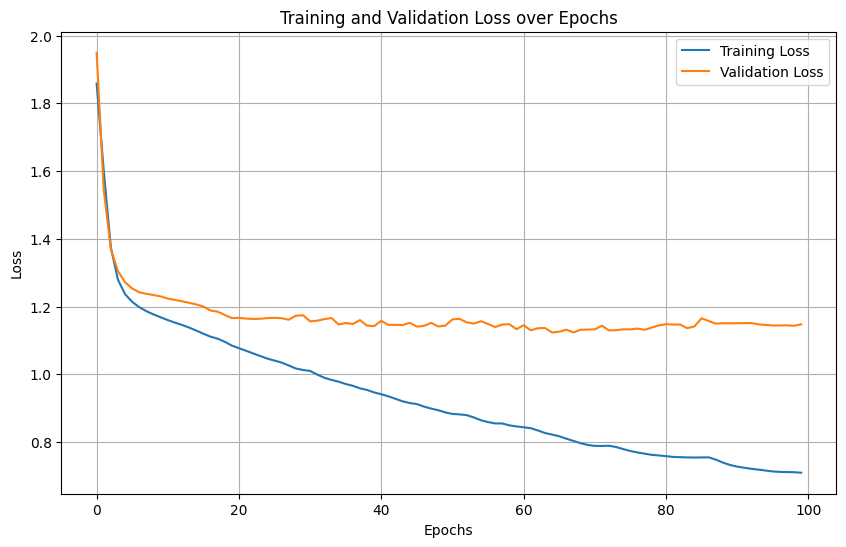

In [86]:
import matplotlib.pyplot as plt

# Assuming 'history' is the result of model.fit()
history_dict = history.history
train_loss = history_dict['loss']
val_loss = history_dict['val_loss']

# Create a plot for loss and validation loss
plt.figure(figsize=(10, 6))
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# **PART 2: Text Summarization**

After converting speech to text, for our **Intelligent Meeting Notes**, we need to summarize the entire meeting. Due to the lack of accuracy of our model, we will use the text data from the dataset instead of the predicted one. 🤗🤗

In [92]:
!pip install transformers

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


In [99]:
text = ''
for i in range(1, 195):
    temp = id_to_text[f"chunk_{i}-boston_ff7cd3a9-f0f6-41f2-8470-62b10d474400.wav"]
    text += temp + " "
    

In [101]:
from transformers import pipeline

# Load summarization pipeline
summarizer = pipeline("summarization", model="Falconsai/text_summarization")

# Generate summary
summary = summarizer(text, max_length=200, min_length=10, do_sample=False)
print("Summary:", summary[0]["summary_text"])

Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.
Token indices sequence length is longer than the specified maximum sequence length for this model (9899 > 512). Running this sequence through the model will result in indexing errors


Summary: I'm excited to see you as a fellow councilor. I want to thank you for your leadership . I've been with you for a long time, and I'll be proud of you . You're going to be an outstanding mayor. And so I'd like to say that you're a friend . We're not able to be a member of the city, but it's not a matter of democracy . It's been a great day for the city of Boston


## **Training and Evaluation**
Initially, the training loss was high at 1.8, but through iterative training, the loss decreased to 0.9, reflecting a notable reduction in the error between the model's predictions and the actual transcriptions. This improvement was consistent across both training and validation data, indicating that the model generalizes well to unseen data.

The evaluation was carried out using a combination of training loss, validation loss, and output inspection. The training loss consistently decreased over epochs, while the validation loss also showed improvement, though with some minor fluctuations, which is common in deep learning training. The model's performance was further evaluated using target vs. predicted transcription comparisons, where the model was able to generate relatively coherent sentences, although still with room for improvement in fluency and accuracy.

### **For example:**

* Target: <the ayes have it. the docket is hereby adopted. congratulations, councilor bach. madam clerk, would you now please read docket #### thank you.>

* Prediction: <thank you. docket #### will be refe the to the re on the on be fon mere comin on the on on the fon mmerere commeran con oforingn ollomman oor plererean.>

* Target: thank you. councilor edwards answer is the chair recognizes the district council from beacon hill councilor kenzie bach. the floor is yours. just wait for.

* Prediction: thank you. the chair recognizes counsel counsel banse or or or onsel mave mur of the or yore ore. f cor.

While these predictions are far from perfect, they demonstrate that the model is able to recognize parts of speech and key phrases, though it still struggles with complex words and longer sentences.

# Challenges and Future Work
While the model shows promising results, there are several challenges that need to be addressed:

1. **Transcription Accuracy:** The model still produces predictions with several errors in terms of word accuracy and fluency, as shown in the examples above. One challenge is that the model struggles with recognizing certain words or phrases correctly, especially with complex terms or those with similar phonetic structures.

2. **Handling Ambiguity:** The model has difficulty resolving ambiguities and maintaining context over longer sentences. It tends to generate incomplete or jumbled predictions, especially when it encounters unknown words or out-of-context phrases.

3. **Model Generalization:** The model's performance is highly dependent on the quality and variety of the training data. While the validation loss has decreased, there is a need to test the model on a more diverse dataset to ensure it generalizes well to other types of meetings and spoken dialogue.

4. **Real-Time Processing:** Currently, the system is trained on pre-recorded audio, and real-time processing capabilities need to be implemented for practical use in live meetings. This would require optimizing the model and its inference speed.